In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, Binarizer
from sklearn.metrics import plot_confusion_matrix, classification_report, f1_score, mean_squared_error, accuracy_score, precision_score, recall_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier

np.random.seed(3792)

In [101]:
kickoff_df = pd.read_csv('../data/kickoffs_2018_model_ready.csv')
kickoff_df.head(1)

,gameId,playId,quarter,kickerId,returnerId,yardlineNumber,penaltyYards,preSnapHomeScore,preSnapVisitorScore,kickLength,kickReturnYardage,absoluteYardlineNumber,hangTime,missedTackler,assistTackler,tackler,week,gameTimeEastern,x,y,s,a,dis,o,dir,nflId,jerseyNumber,team,frameId,playDirection,yardlineSide_ARI,yardlineSide_ATL,yardlineSide_BAL,yardlineSide_BUF,yardlineSide_CAR,yardlineSide_CHI,yardlineSide_CIN,yardlineSide_CLE,yardlineSide_DAL,yardlineSide_DEN,yardlineSide_DET,yardlineSide_GB,yardlineSide_HOU,yardlineSide_IND,yardlineSide_JAX,yardlineSide_KC,yardlineSide_LA,yardlineSide_LAC,yardlineSide_MIA,yardlineSide_MIN,yardlineSide_NE,yardlineSide_NO,yardlineSide_NYG,yardlineSide_NYJ,yardlineSide_OAK,yardlineSide_PHI,yardlineSide_PIT,yardlineSide_SEA,yardlineSide_SF,yardlineSide_TB,yardlineSide_TEN,yardlineSide_WAS,yardlineSide_midfield,kickType_D,kickType_K,kickType_P,kickType_Q,kickDirectionIntended_C,kickDirectionIntended_L,kickDirectionIntended_R,kickDirectionActual_C,kickDirectionActual_L,kickDirectionActual_R,returnDirectionIntended_C,returnDirectionIntended_L,returnDirectionIntended_R,returnDirectionActual_C,returnDirectionActual_L,returnDirectionActual_R,kickoffReturnFormation_5-3-2,kickoffReturnFormation_6-0-3,kickoffReturnFormation_6-0-4,kickoffReturnFormation_6-2-2,kickoffReturnFormation_7-0-3,kickoffReturnFormation_8-0-1,kickoffReturnFormation_8-0-2,kickoffReturnFormation_8-1-1,position_CB,position_DB,position_DE,position_DL,position_DT,position_FB,position_FS,position_G,position_HB,position_ILB,position_K,position_LB,position_LS,position_MLB,position_OLB,position_P,position_QB,position_RB,position_S,position_SS,position_TE,position_WR
0,2018090600,677,1,37267,44979,35,0,0,3,64,30,75,4.06,1,1,1,1,9,79.22,26.19,4.47,1.58,0.44,289.13,305.37,37267,5,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [102]:
kickoff_df['assistTackler'].value_counts()

0    1277069
1     390730
2     193684
Name: assistTackler, dtype: int64

In [103]:
#Messed up in previous notebook currently flipped around as our 2 class is NT or No Tackle which should be our 0 class, etc.
kickoff_df['assistTackler'] = kickoff_df['assistTackler'].map({0 : 'Solo', 1 : 'assist', 2: 'NT'})

In [104]:
kickoff_df['assistTackler'] = kickoff_df['assistTackler'].map({
    'NT' : 0,
    'Solo' : 1,
    'assist' : 2
})

In [106]:
kickoff_df['assistTackler'].value_counts()

1    1277069
2     390730
0     193684
Name: assistTackler, dtype: int64

# Modeling Steps 
1. Re-run the simple Linear Regression to see how well our data can predict the exact length of a return.
1. Run through binary classification models
1. If time run through multi-class classification models

In [114]:
#We have a much larger dataset now so we can likely get away with a 2/3 : 1/3 train to test split
kickoff_df.shape

(1861483, 109)

In [115]:
X = kickoff_df.drop(columns='kickReturnYardage')
y = kickoff_df['kickReturnYardage']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   random_state=3792,
                                                   train_size= 2/3)

In [116]:
lr = LinearRegression()

In [117]:
lr.fit(X_train, y_train)

LinearRegression()

In [118]:
#Well we improved slighlty (previous was around .16 to .13 )
lr.score(X_train, y_train) , lr.score(X_test, y_test)

(0.2881484496573481, 0.28951887706338264)

In [120]:
linreg_coefs = pd.DataFrame(zip( X.columns, (lr.coef_)), 
             columns=['Feature', 'Coef'])
linreg_coefs.head()

,Feature,Coef
0,gameId,0.000366
1,playId,-0.000345
2,quarter,0.743376
3,kickerId,-0.000135
4,returnerId,-0.000159


In [123]:
linreg_coefs[linreg_coefs['Coef'] >0].sort_values('Coef', ascending=False)[0:10]

,Feature,Coef
47,yardlineSide_MIA,12.398921
65,kickType_Q,10.906608
78,kickoffReturnFormation_5-3-2,9.534217
83,kickoffReturnFormation_8-0-1,6.322281
84,kickoffReturnFormation_8-0-2,6.257543
28,playDirection,4.686088
59,yardlineSide_TEN,3.784996
56,yardlineSide_SEA,3.610547
66,kickDirectionIntended_C,3.324938
11,hangTime,2.967985


In [124]:
#Not any better
round((mean_squared_error(y_true=y_test, y_pred=lr.predict(X_test)) ** .5), 4)

10.9555

### Interpretation
* Not any better

### Kick Return Info to set up binary class

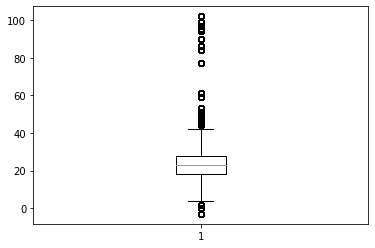

In [125]:
plt.boxplot(kickoff_df['kickReturnYardage']);

In [126]:
kickoff_df['kickReturnYardage'].mean()

24.746446247427453

In [127]:
kickoff_df['kickReturnYardage'].median()

23.0

In [128]:
kickoff_df['kickReturnYardage'] = kickoff_df['kickReturnYardage'].map(lambda kickReturnYardage : 1 if kickReturnYardage >= 25 else 0)
kickoff_df[['kickReturnYardage']].head()

,kickReturnYardage
0,1
1,1
2,1
3,1
4,1


## Logisitc Regression
* Setting a successful return as a kick return that gains 25 or more yards as the 

In [129]:
#baseline 
kickoff_df['kickReturnYardage'].value_counts(normalize=True)

0    0.589474
1    0.410526
Name: kickReturnYardage, dtype: float64

So our Baseline model would predict a successful kickoff return on ~41% of our returns.

In [130]:
#Train test split to .8 to .2 due to the smaller data set, I want to give the training set as much to train on
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   random_state=3792,
                                                   train_size= 2/3,
                                                   stratify= y)

In [131]:
y_train.value_counts() , y_train.value_counts(normalize=True)

(0    731530
 1    509458
 Name: kickReturnYardage, dtype: int64,
 0    0.589474
 1    0.410526
 Name: kickReturnYardage, dtype: float64)

In [132]:
y_test.value_counts() , y_test.value_counts(normalize=True)

(0    365766
 1    254729
 Name: kickReturnYardage, dtype: int64,
 0    0.589475
 1    0.410525
 Name: kickReturnYardage, dtype: float64)

Distribution of unsuccessful : successful is essentially the same for train and test.

In [133]:
log_reg = LogisticRegression()
log_reg.fit(X=X_train, y=y_train)

LogisticRegression()

In [134]:
round(log_reg.score(X_train, y_train), 4)

0.5895

In [135]:
round(log_reg.score(X_test, y_test), 4)

0.5895

In [136]:
f1_score(y_true=y_test, y_pred= log_reg.predict(X_test))

0.0

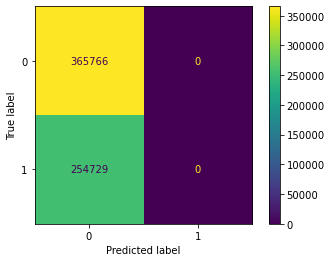

In [191]:
plot_confusion_matrix(estimator=log_reg,
                      X=X_test, 
                      y_true=y_test)
plt.savefig('../images/full_logreg_conf_matrix.png');

In [199]:
round(accuracy_score(y_true=y_test, y_pred= log_reg.predict(X_test)), 4)

0.5895

In [200]:
round(precision_score(y_true=y_test, y_pred= log_reg.predict(X_test)), 4)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0

#### Interpretation
We are still running into the same issues as before with low prediction improvements and we still aren't predicting our positive class at all!

### KNN

In [138]:
sc = StandardScaler()

In [139]:
X_train_sc = sc.fit_transform(X_train)
X_test_sc  = sc.fit_transform(X_test)

In [29]:
KNeighborsClassifier().get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [34]:
# %%time

# knn_gs = GridSearchCV(estimator=KNeighborsClassifier(),
#                      param_grid={
#                          'n_neighbors' : range(1, 101, 10),
#                          'p' : [1, 2]}, 
#                       cv= 5, 
#                       verbose= 1)
# knn_gs.fit(X_train_sc, y_train)

### Decisison Tree Classifier

In [140]:
DecisionTreeClassifier().get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [39]:
# %%time

# dt_gs = GridSearchCV(estimator=DecisionTreeClassifier(),
#                     param_grid={
#                         'max_depth' : [1,2,3,4],
#                         'max_features' : [1,2,3],
#                         'min_samples_leaf' : [1,2,3,4],
#                         'min_samples_split' : [2, 4, 6]
#                     })
# dt_gs.fit(X_train_sc, y_train)

Wall time: 10min 45s


GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [1, 2, 3, 4], 'max_features': [1, 2, 3],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [2, 4, 6]})

In [41]:
# dt_gs.best_params_

{'max_depth': 4,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 2}

In [45]:
# 0.6364
# round(dt_gs.best_score_, 4)

0.6364

In [46]:
# round(dt_gs.score(X_train_sc, y_train), 4)
#0.6203

0.6203

In [47]:
# round(dt_gs.score(X_test_sc, y_test), 4)
# 0.6207

0.6207

In [202]:
# plot_confusion_matrix(estimator=dt_gs,
#                      X=X_test_sc,
#                      y_true=y_test) 
# plt.savefig('../images/dt_first_conf_matrix.png');

#### DT GS 2

In [143]:
%%time

dt_gs2 = GridSearchCV(estimator=DecisionTreeClassifier(),
                    param_grid={
                        'max_depth' : [3,4,5,6],
                        'max_features' : [2,3,4,5],
                        'min_samples_leaf' : [2,3,4,5],
                        'min_samples_split' : [2, 3, 4]
                    }, verbose=1, cv=5)
dt_gs2.fit(X_train_sc, y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
Wall time: 20min 23s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [3, 4, 5, 6],
                         'max_features': [2, 3, 4, 5],
                         'min_samples_leaf': [2, 3, 4, 5],
                         'min_samples_split': [2, 3, 4]},
             verbose=1)

In [144]:
# # dt_gs2.best_params_
# {'max_depth': 6,
#  'max_features': 5,
#  'min_samples_leaf': 3,
#  'min_samples_split': 3}

{'max_depth': 6,
 'max_features': 5,
 'min_samples_leaf': 3,
 'min_samples_split': 3}

In [147]:
#That's better!
round(dt_gs2.best_score_, 4)

0.6863

In [149]:
round(dt_gs2.score(X_train_sc, y_train), 6), round(dt_gs2.score(X_test_sc, y_test), 6)

(0.656002, 0.656002)

In [152]:
#Not the best, still may be under predicting our positive class, but lets check the matrix
round(f1_score(y_true=y_test, y_pred=dt_gs2.predict(X_test_sc)), 4)

0.5302

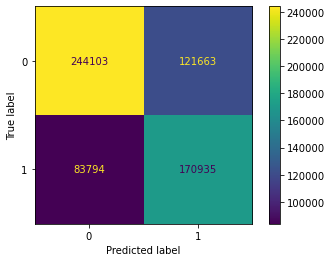

In [192]:
plot_confusion_matrix(estimator=dt_gs2,
                      X=X_test_sc,
                      y_true= y_test)
plt.savefig('../images/full_dt_conf_matrix.png', bbox_inches = 'tight');

#### DT Classification Metrics

In [153]:
round(accuracy_score(y_true=y_test, y_pred=dt_gs2.predict(X_test_sc)), 4)

0.656

In [155]:
#We're still doing better than our baseline
round(recall_score(y_true=y_test, y_pred=dt_gs2.predict(X_test_sc)), 4)

0.4729

In [154]:

round(precision_score(y_true=y_test, y_pred=dt_gs2.predict(X_test_sc)), 4)

0.6034

#### DT Metrics Interpret
* We maybe slightly over predicting the number of successful kick returns based on the confusion matrix.
* Even so our accuracy, recall, and precision scores are all well above baseline.
* We can consider this a success!

In [161]:
dt_coefs = pd.DataFrame(zip(X.columns, dt_gs2.best_estimator_.feature_importances_), columns=['Feature', 'Coef'])
dt_coefs.head()

,Feature,Coef
0,gameId,0.000000
1,playId,0.030274
2,quarter,0.015427
3,kickerId,0.000000
4,returnerId,0.022452


In [163]:
#updating to just positive coefs
dt_coefs = dt_coefs[dt_coefs['Coef'] > 0]
dt_coefs.sort_values('Coef', ascending=False)[0:5]

,Feature,Coef
75,returnDirectionActual_C,0.237838
73,returnDirectionIntended_L,0.115773
64,kickType_P,0.072741
71,kickDirectionActual_R,0.055275
9,kickLength,0.049565


In [168]:
#setting coefs Descending
dt_coefs = dt_coefs.sort_values('Coef', ascending=False)
dt_coefs.head()

,Feature,Coef
75,returnDirectionActual_C,0.237838
73,returnDirectionIntended_L,0.115773
64,kickType_P,0.072741
71,kickDirectionActual_R,0.055275
9,kickLength,0.049565


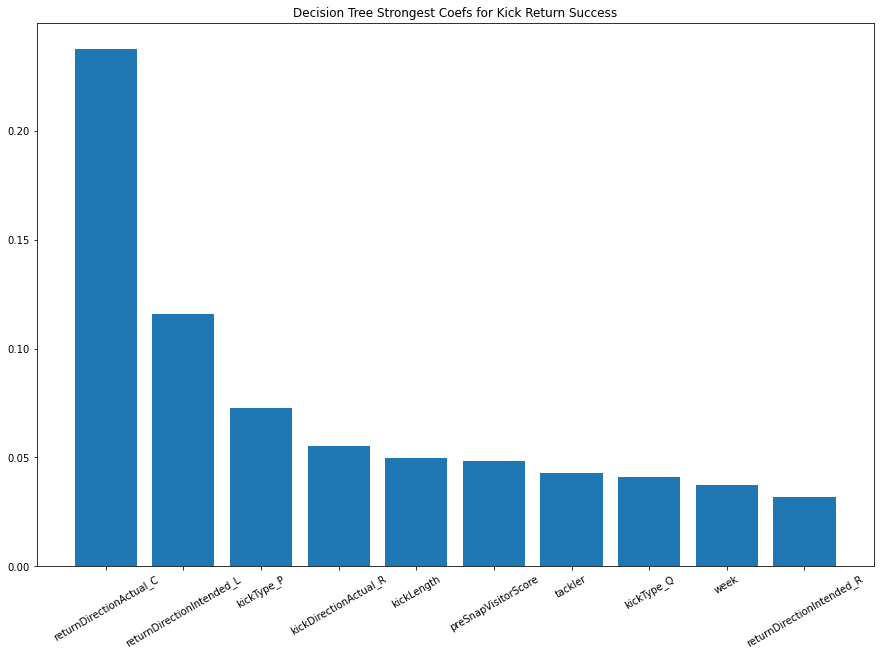

In [194]:
plt.figure(figsize=(15,10))
plt.bar(dt_coefs['Feature'][:10] , dt_coefs['Coef'][:10])
plt.xticks(rotation = 30)
plt.title('Decision Tree Strongest Coefs for Kick Return Success')
plt.savefig('../images/dt_coefs.png', bbox_inches = 'tight');

In [226]:
np.exp(0.237838)

1.2685036785827764

In [225]:
dt_coefs['Coef'].head(1)

75    0.237838
Name: Coef, dtype: float64

### Bagged Decision Tree

In [177]:
BaggingClassifier().get_params()

{'base_estimator': None,
 'bootstrap': True,
 'bootstrap_features': False,
 'max_features': 1.0,
 'max_samples': 1.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [179]:
%%time

bg_gs = GridSearchCV(estimator=BaggingClassifier(),
                    param_grid={
                        'max_features' : [2,3,4,5],
                        'max_samples' : [2,3,4,5],
                        'n_estimators' : range(10,36,5)
                    }, verbose=1, cv=5)
bg_gs.fit(X_train_sc, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Wall time: 21min 13s


GridSearchCV(cv=5, estimator=BaggingClassifier(),
             param_grid={'max_features': [2, 3, 4, 5],
                         'max_samples': [2, 3, 4, 5],
                         'n_estimators': range(10, 36, 5)},
             verbose=1)

In [180]:
bg_gs.best_params_

{'max_features': 5, 'max_samples': 3, 'n_estimators': 30}

In [181]:
bg_gs.best_score_

0.5954981170761522

In [182]:
round(bg_gs.score(X_train_sc, y_train), 4) , round(bg_gs.score(X_test_sc, y_test), 4)

(0.593, 0.5934)

In [183]:
round(f1_score(y_true=y_test, y_pred=bg_gs.predict(X_test_sc)), 4)

0.0734

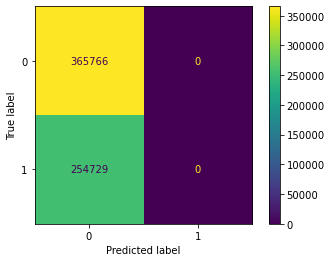

In [197]:
plot_confusion_matrix(estimator=bg_gs, X=X_test, y_true= y_test)
plt.savefig('../images/bg_dt_conf_matrix.png', bbox_inches = 'tight');

#### Bag Class Interp
Bagging classifier suffers from the same issues as the logistic regression in not predicting the positive class

### Random Forest Classifier

In [186]:
RandomForestClassifier().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [216]:
# %%time

# rf_gs = GridSearchCV(estimator=RandomForestClassifier(),
#                     param_grid={
#                         'max_depth' : [None, 1, 2, 3],
#                         'max_features' : [2,3,4,5],
#                         'n_estimators' : [100, 200, 300],
#                         'ccp_alpha' : [0, .001, .001, .01, 1]
#                     }, verbose=1, cv=5)
# rf_gs.fit(X_train_sc, y_train)